# Term1 Sprint1
## Sprintの目的
- 機械学習の実践的な流れを知る
- 高い汎化性能を持つモデルを完成させる

丁寧な検証が行える状態にした上で、他者の解法を参考に汎化性能の高いモデル作りを進めます。

## 機械学習フロー

Kaggleの Home Credit Default Risk コンペティションを題材に、機械学習の実践的な流れを学びます。特に適切な 検証 を行い、高い 汎化性能 のあるモデルを完成させることを目指します。

## 【問題1】クロスバリデーション
---

事前学習期間では検証用データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。
事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。




In [1]:
#基本ライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#データセットの読み込み
pd.set_option('display.max_columns', 100)

df_raw = pd.read_csv("../home-credit-default-risk/application_train.csv")
df_raw.head(30)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary sp

In [44]:
#ターゲットとの相関が高い特徴量を調べる
df_raw_corr = np.abs(df_raw.corr().iloc[: , 1])
df_raw_corr.sort_values(ascending = False).head(20)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
Name: TARGET, dtype: float64

In [4]:
#中央値の生成
median1 = df_raw["EXT_SOURCE_1"].median()
median2 = df_raw["EXT_SOURCE_2"].median()
median3 = df_raw["EXT_SOURCE_3"].median()

print("EXT_SOURCE_1の中央値：{}".format(median1))
print("EXT_SOURCE_2の中央値：{}".format(median2))
print("EXT_SOURCE_3の中央値：{}".format(median3))
print("---------------------------------------------------------------")

#DataFrameのコピー
df_fill = df_raw.copy()

#df_fill = df_fill.query('EXT_SOURCE_3 != 0.000527')
df_fill = df_fill.query("EXT_SOURCE_2 < 0.855")


#中央値で補完
df_fill["EXT_SOURCE_1"].fillna(0, inplace=True)
df_fill["EXT_SOURCE_2"].fillna(0, inplace=True)
df_fill["EXT_SOURCE_3"].fillna(0, inplace=True)
df_fill["DAYS_BIRTH"].fillna(0, inplace=True)
df_fill["DAYS_LAST_PHONE_CHANGE"].fillna(0, inplace=True)
df_fill["DAYS_ID_PUBLISH"].fillna(0, inplace=True)

###なお、scikit-learnのImputerクラスでも同様のことが可能

print(df_fill.info())

#TARGET及び特徴量選択
df = df_fill.loc[: , ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
                        "DAYS_BIRTH",  "REGION_RATING_CLIENT_W_CITY", "REGION_RATING_CLIENT",
                      "DAYS_LAST_PHONE_CHANGE", "DAYS_ID_PUBLISH", "REG_CITY_NOT_WORK_CITY", "TARGET"]]

#df = df.dropna(how = "any")

#分割
y = df.loc[: , "TARGET"]
X = df.iloc[: , :9]

X.info()

EXT_SOURCE_1の中央値：0.5059979305057544
EXT_SOURCE_2の中央値：0.5659614260608526
EXT_SOURCE_3の中央値：0.5352762504724826
---------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 306851 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 288.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 306851 entries, 0 to 307510
Data columns (total 9 columns):
EXT_SOURCE_1                   306851 non-null float64
EXT_SOURCE_2                   306851 non-null float64
EXT_SOURCE_3                   306851 non-null float64
DAYS_BIRTH                     306851 non-null int64
REGION_RATING_CLIENT_W_CITY    306851 non-null int64
REGION_RATING_CLIENT           306851 non-null int64
DAYS_LAST_PHONE_CHANGE         306851 non-null float64
DAYS_ID_PUBLISH                306851 non-null int64
REG_CITY_NOT_WORK_CITY         306851 non-null int64
dtypes: float64(4), 

## 特徴量エンジニアリングを施したデータを改めて分析してみる
---

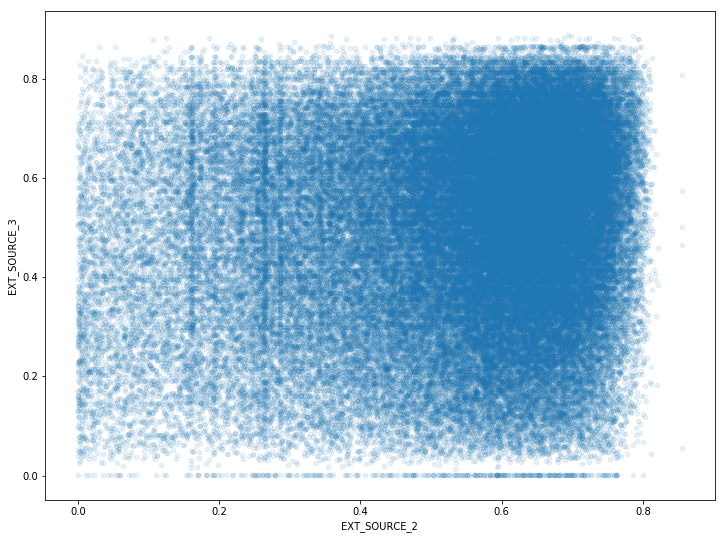

In [50]:
#EXT_SOURCE_3、EXT_SOURCE_2とDAYS_BIRTHの関係を知る
X.plot(kind="scatter", x="EXT_SOURCE_2", y="EXT_SOURCE_3", alpha=0.1, figsize=(12,9))

上図では、EXT_SOURCE_2を横軸、EXT_SOURCE_3を縦軸に散布図を描いている。また、alpha（透明）を設定することで、データの集中する場所が見て取れる。どうやら、両特徴量とも0.6〜0.7あたりに集中しているようだ。

また、EXT_SOURCE_3には下限として０が設定されているようであり、考えようによってはこのサンプルは除いた方が良い。

さらに、EXT_SOURCE_2には0.17と2.8付近に線があり、何らかのデータの「癖」がある。この癖を学習させないようにこの区域も除いた方がより精度は上がると考えられる。

---

続いて、DAYS_BIRTHの情報を色として乗せてみる。


'\ncオプションのカラーマップとして「jet」を指定している。\nplotのオプションとして「s」を設定すると、色情報ではなく、円の大きさを情報として可視化する。\n'

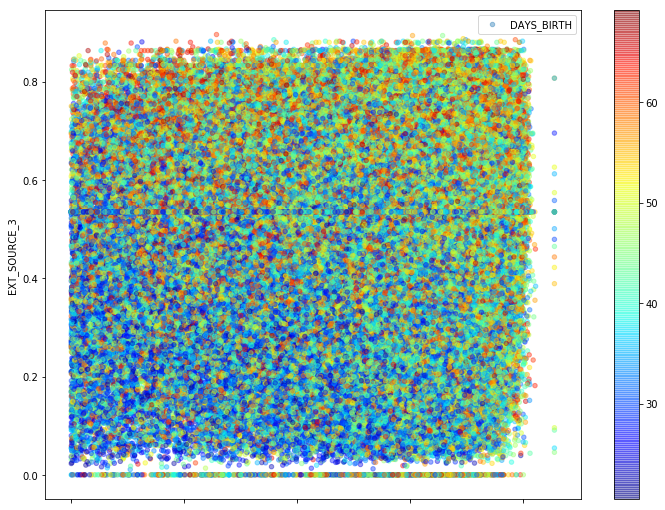

In [17]:
X.plot(kind="scatter", x="EXT_SOURCE_2", y="EXT_SOURCE_3", alpha=0.4,
      c=X["DAYS_BIRTH"]/-365, cmap=plt.get_cmap("jet"), colorbar=True, label="DAYS_BIRTH", figsize=(12,9))
plt.legend()

"""
cオプションのカラーマップとして「jet」を指定している。
plotのオプションとして「s」を設定すると、色情報ではなく、円の大きさを情報として可視化する。
"""


EXT_SOURCE_2とEXT_SOURCE_3の値が高いほど、年齢も高くなる傾向にあることが分かる。

In [7]:
from tqdm import tqdm_notebook as tqdm
import time

#交差検証

from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

#インスタンス化
kf = KFold(n_splits = 4)
"""
kf.split(<dataflame>) で分割するものを渡す。返ってくるのはインデックス。
"""

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

#cross_val_scoreを使用する
from sklearn.model_selection import cross_val_score

for _ in tqdm(range(100)):
    result = cross_val_score(lr, X, y, cv = kf, scoring = "roc_auc")

print(result)
print("平均", sum(result)/4)


[0.60087131 0.60368068 0.59737932 0.60291933]
平均 0.6012126598279105


In [12]:
#LightGBM
import lightgbm as lgb

dftrainLGB = lgb.Dataset(data = X, label = y)
params = {'objective': 'regression'}

cv_results = lgb.cv(
    params, dftrainLGB, num_boost_round=100, nfold=3, metrics="auc", early_stopping_rounds=10
)
print(sum(cv_results["auc-mean"])/ len(cv_results["auc-mean"]))

0.7289836475371748


## 【問題2】グリッドサーチ

これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。
scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。



In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()

param_grid = {"C": [ 0.01, 0.1, 1, 10, 100]}

for _ in tqdm(range(100)):
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring="roc_auc")
    grid_search.fit(X, y)

print('Test set score: {}'.format(grid_search.score(X, y)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))


Test set score: 0.583015816217153
Best parameters: {'C': 0.01}
Best cross-validation: 0.5830347726661447


In [13]:
print(lr)
print(grid_search)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)


## 課題

EXT_SOURCEの欠損値を削除したデータセットで学習しているので、テストデータで精度が出ない可能性

## 【問題3】Kernelからの調査
---
- 特徴量エンジニアリング

  - EXT_SOURCEのデータの癖を無くす
  - 特徴量エンジニアリングで、EXT_SOURCEの値を二乗してみる

- Model Tuning

  - Grid SearchよりRandom Search？
  https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
  
  - Bayesian Optimizationを使ってみる
  https://www.kaggle.com/willkoehrsen/automated-model-tuning
  
  

#### ◇EXT_SOURCEのデータの癖を無くす

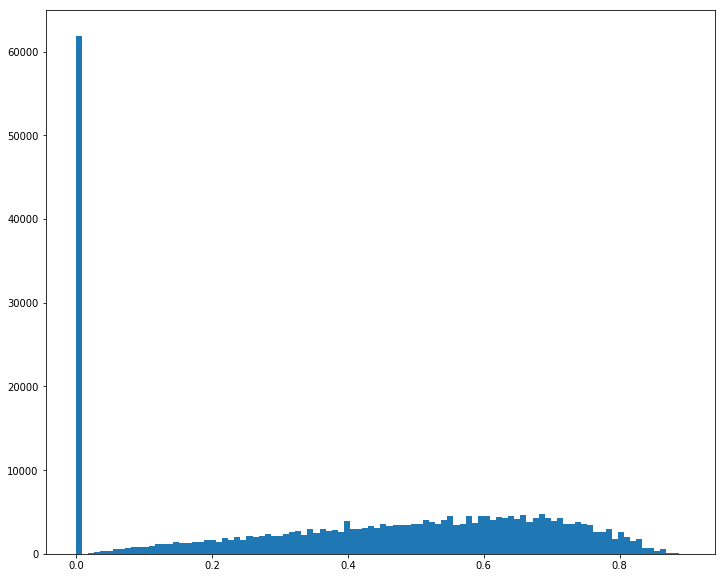

In [60]:
plt.figure(figsize=(12,10))
plt.hist(df['EXT_SOURCE_3'], bins=100)
plt.show()

ヒストグラムを見ると、ゼロ付近に１つ癖があるのと、中央値で補完した箇所が突出している

In [88]:
df.query('EXT_SOURCE_3 < 0.02').head(15)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,TARGET
1,0.311267,0.622246,0.0,-16765,1,1,-828.0,-291,0,0
3,0.000000,0.650442,0.0,-19005,2,2,-617.0,-2437,0,0
4,0.000000,0.322738,0.0,-19932,2,2,-1106.0,-3458,1,0
9,0.000000,0.746644,0.0,-14469,2,2,-1673.0,-3992,0,0
14,0.721940,0.642656,0.0,-14583,1,2,-188.0,-2056,0,0
17,0.000000,0.683513,0.0,-9776,2,2,-2811.0,-2427,1,0
20,0.565655,0.113375,0.0,-18252,2,2,-296.0,-1800,0,0
29,0.297914,0.502779,0.0,-10341,2,2,-599.0,-3015,0,0
31,0.274422,0.627300,0.0,-11144,2,2,-397.0,-2904,0,0
34,0.000000,0.172498,0.0,-15997,2,2,-3019.0,-4067,0,0


In [92]:
df.query('EXT_SOURCE_3 < 0.02').EXT_SOURCE_3.value_counts()

0.000000    60735
0.000527      886
0.019059        2
0.016777        2
0.012716        1
0.016078        1
0.018658        1
0.016541        1
0.017506        1
0.014148        1
0.019468        1
0.014556        1
0.011346        1
0.018137        1
0.013948        1
0.017017        1
0.018266        1
0.018924        1
Name: EXT_SOURCE_3, dtype: int64

「0.000527」が８８６データと多くなっている。

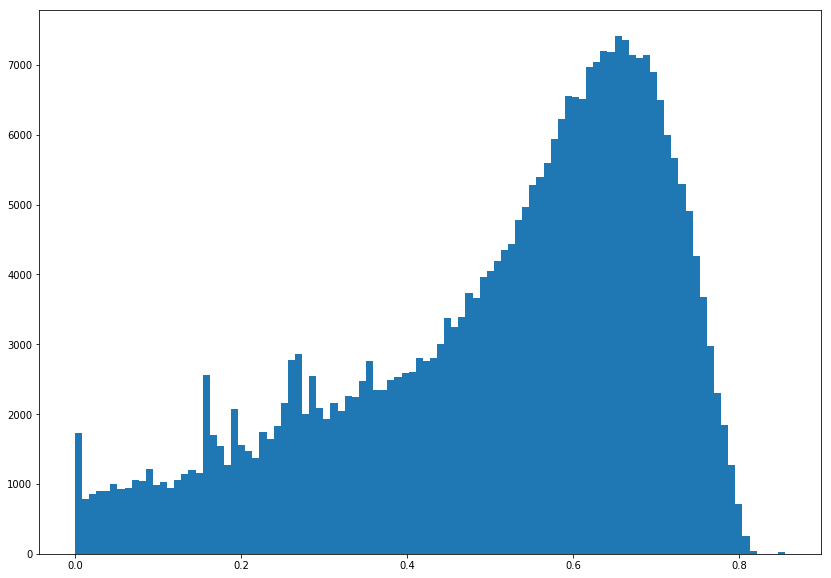

In [62]:
plt.figure(figsize=(14,10))
plt.hist(df['EXT_SOURCE_2'], bins=100)
plt.show()

In [42]:
df.query('EXT_SOURCE_2 > 0.85').EXT_SOURCE_2.value_counts()

0.855    26
Name: EXT_SOURCE_2, dtype: int64

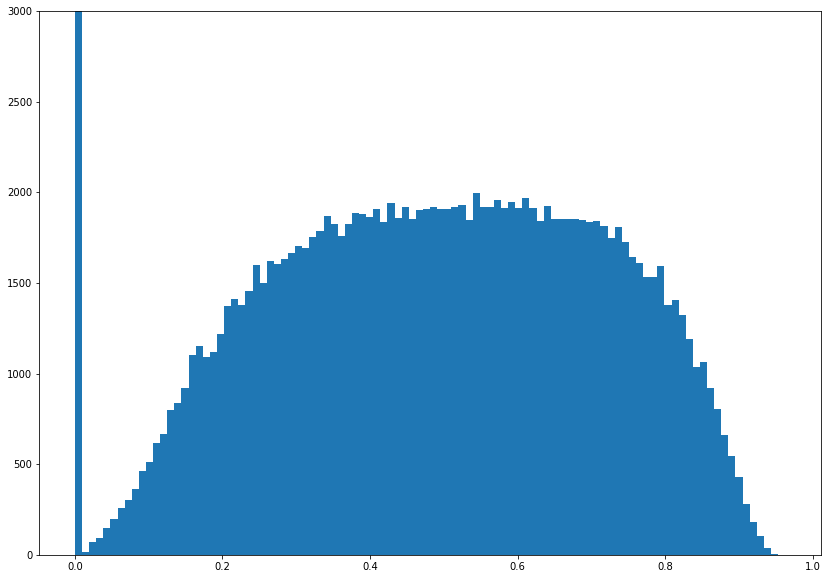

In [63]:
plt.figure(figsize=(14,10))
plt.ylim(0, 3000)
plt.hist(df['EXT_SOURCE_1'], bins=100)
plt.show()

In [ ]:
#df = df.query('EXT_SOURCE_3 > 0.000527')
#df = df.query("EXT_SOURCE_2 < 0.855")

#### ONE HOT ENCODING
targetとの相関が高い係数の中に、カテゴリ変数が見られる。objectタイプのカテゴリ変数について、ワンホットエンコーディングを行うことで、より相関の高い特徴量を創出したい。

In [54]:
#ORGANIZATION_TYPEのワンホット化

cat = df_raw.ORGANIZATION_TYPE.value_counts().index.values

ORGANIZATION_TYPE_1hot = pd.get_dummies(df_raw["ORGANIZATION_TYPE"], columns = cat)

df = df_fill.loc[: , ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
                        "DAYS_BIRTH",  "REGION_RATING_CLIENT_W_CITY", "REGION_RATING_CLIENT",
                      "DAYS_LAST_PHONE_CHANGE", "DAYS_ID_PUBLISH", "REG_CITY_NOT_WORK_CITY", "TARGET"]]

df = pd.concat([ORGANIZATION_TYPE_1hot, df], axis=1) 
#df = df.dropna(how = "any")

df_corr = np.abs(df.corr().iloc[: , -1])
df_corr.sort_values(ascending = False).head(30)

TARGET                         1.000000
EXT_SOURCE_2                   0.160472
EXT_SOURCE_3                   0.119805
DAYS_BIRTH                     0.078152
EXT_SOURCE_1                   0.064819
REGION_RATING_CLIENT_W_CITY    0.060938
REGION_RATING_CLIENT           0.058951
DAYS_LAST_PHONE_CHANGE         0.055132
DAYS_ID_PUBLISH                0.051326
REG_CITY_NOT_WORK_CITY         0.051146
XNA                            0.045930
Self-employed                  0.029059
Business Entity Type 3         0.024092
Construction                   0.019736
Transport: type 3              0.017615
School                         0.013598
Medicine                       0.010653
Restaurant                     0.010275
Military                       0.010026
Police                         0.009835
Industry: type 3               0.009798
Bank                           0.009586
Security Ministries            0.009443
Trade: type 3                  0.008756
Trade: type 7                  0.008104


In [55]:
df["XNA"].value_counts()

0    252137
1     55374
Name: XNA, dtype: int64

XNAが相関がやや高く出たので、これを使用してみたい。

In [56]:
df = df.loc[: , ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
                        "DAYS_BIRTH",  "REGION_RATING_CLIENT_W_CITY", "REGION_RATING_CLIENT",
                      "DAYS_LAST_PHONE_CHANGE", "DAYS_ID_PUBLISH", "REG_CITY_NOT_WORK_CITY", "XNA", "TARGET"]]

#分割
y = df.loc[: , "TARGET"]
X = df.iloc[: , :10]

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 10 columns):
EXT_SOURCE_1                   306851 non-null float64
EXT_SOURCE_2                   306851 non-null float64
EXT_SOURCE_3                   306851 non-null float64
DAYS_BIRTH                     306851 non-null float64
REGION_RATING_CLIENT_W_CITY    306851 non-null float64
REGION_RATING_CLIENT           306851 non-null float64
DAYS_LAST_PHONE_CHANGE         306851 non-null float64
DAYS_ID_PUBLISH                306851 non-null float64
REG_CITY_NOT_WORK_CITY         306851 non-null float64
XNA                            307511 non-null uint8
dtypes: float64(9), uint8(1)
memory usage: 23.8 MB


In [59]:
#LogisticRegression
lr = LogisticRegression()

for _ in tqdm(range(100)):
    result = cross_val_score(lr, X, y, cv = kf, scoring = "roc_auc")

print(result)
print("平均", sum(result)/4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [57]:
#LightGBM
dftrainLGB = lgb.Dataset(data = X, label = y)
params = {'objective': 'regression'}

cv_results = lgb.cv(
    params, dftrainLGB, num_boost_round=100, nfold=3, metrics="auc", early_stopping_rounds=15
)
print(sum(cv_results["auc-mean"])/ len(cv_results["auc-mean"]))

0.730061442104016
